<a href="https://colab.research.google.com/github/OfEarthAndEther/AI_monologues/blob/main/Mantis_Search_Optimizer/MSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mantis Search Algorithm**

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

# --- 1. THE HELPER FUNCTIONS ---

In [2]:
def levy_flight(dim):
    """
    Mathematical modeling of the search/pursuit phase.
    Generates a heavy-tailed step to allow for broad exploration.
    """
    beta = 1.5
    # Fix: Use the standard math.gamma instead of numpy's sub-module
    sigma = (math.gamma(1 + beta) * np.sin(np.pi * beta / 2) /
            (math.gamma((1 + beta) / 2) * beta * 2**((beta - 1) / 2)))**(1 / beta)

    u = np.random.randn(dim) * sigma
    v = np.random.randn(dim)
    step = u / abs(v)**(1 / beta)
    return step

def objective_function(x):
    """
    The problem to solve: Sphere Function.
    Global optimum is at f(0,0...0) = 0.
    """
    return np.sum(x**2)

# --- 2. THE OPTIMIZER CONFIGURATION ---

In [3]:
dim = 10          # Number of variables
lb = -100         # Lower search boundary
ub = 100          # Upper search boundary
pop_size = 30     # N: Population of mantises
max_iter = 100    # T: Maximum generations

# Initialize Population
X = np.random.uniform(lb, ub, (pop_size, dim))
fitness = np.array([objective_function(ind) for ind in X])

# Find the initial best mantis
best_idx = np.argmin(fitness)
best_pos = X[best_idx].copy()
best_score = fitness[best_idx]

convergence_curve = []

# --- 3. THE MAIN OPTIMIZATION LOOP ---

In [4]:
for t in range(max_iter):
    for i in range(pop_size):
        r = np.random.random()

        # PHASE 1: SEARCH & PURSUIT (Exploration)
        if r < 0.5:
            step = levy_flight(dim)
            # Use Levy flight to jump to distant areas of the search space
            X[i] = X[i] + 0.01 * step * (X[i] - best_pos)

        # PHASE 2: STRIKE & CAPTURE (Exploitation)
        else:
            # Random local walk around the best solution found so far
            X[i] = best_pos + np.random.randn() * (best_pos - X[i])

        # PHASE 3: SEXUAL CANNIBALISM (Stochastic Jump)
        # 10% chance to reset a mantis to a random position to avoid local optima
        if np.random.random() < 0.1:
            X[i] = np.random.uniform(lb, ub, dim)

        # Boundary Handling (Clip values to [lb, ub])
        X[i] = np.clip(X[i], lb, ub)

        # Selection: Update if the new position is better
        f_new = objective_function(X[i])
        if f_new < fitness[i]:
            fitness[i] = f_new
            if f_new < best_score:
                best_score = f_new
                best_pos = X[i].copy()

    convergence_curve.append(best_score)

    if (t+1) % 10 == 0:
        print(f"Iteration {t+1}/{max_iter} | Best Score: {best_score:.4e}")

Iteration 10/100 | Best Score: 2.1263e+03
Iteration 20/100 | Best Score: 8.1120e+02
Iteration 30/100 | Best Score: 6.0532e+02
Iteration 40/100 | Best Score: 2.2683e+02
Iteration 50/100 | Best Score: 7.9480e+01
Iteration 60/100 | Best Score: 6.6375e+01
Iteration 70/100 | Best Score: 4.9081e+01
Iteration 80/100 | Best Score: 1.9490e+01
Iteration 90/100 | Best Score: 1.0485e+01
Iteration 100/100 | Best Score: 5.5480e+00


# --- 4. VISUALIZATION ---

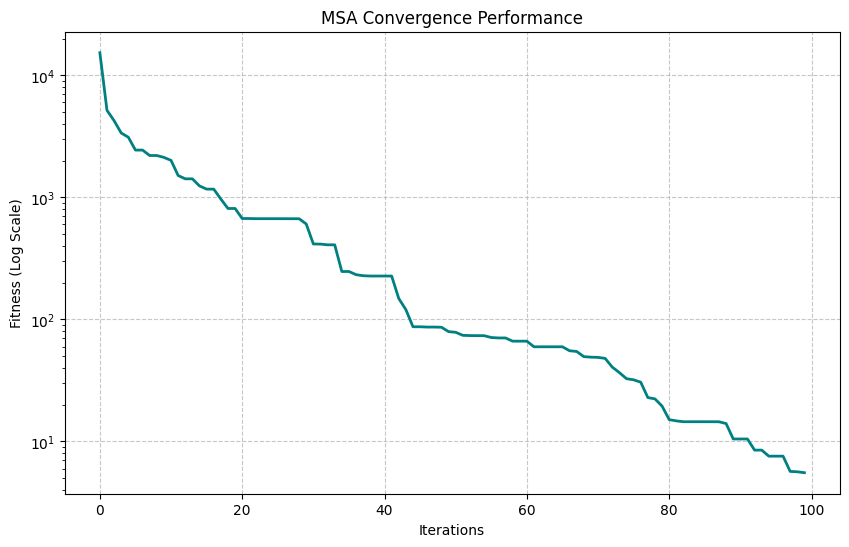

In [5]:
plt.figure(figsize=(10, 6))
plt.semilogy(convergence_curve, color='teal', linewidth=2)
plt.title('MSA Convergence Performance')
plt.xlabel('Iterations')
plt.ylabel('Fitness (Log Scale)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()